# Dimensionality reduction

In [13]:
from pymongo import MongoClient
from gensim.models import Word2Vec
import gensim
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import networkx as nx
from itertools import combinations
import community
from collections import defaultdict
import randomcolor
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.special import comb
from scipy.spatial.distance import pdist

## Load vector file of inclusion criteria 

In [2]:
inclusion_vectors = pickle.load(open("vectorized_criteria.p", 'rb'))

## Dimensionality reduction of asthma inclusion criteria with PCA 

### Remove rows with NaN

#### Get index of rows with NaN that will be removed - to track study ids later 

In [3]:
drop_index = np.argwhere(np.isnan(inclusion_vectors))
drop_row_index = drop_index[:,0]

In [4]:
drop_index.shape

(18900, 2)

There are 63 rows that are completely devoid of information - maybe they are too short, or don't have any of the key words

In [5]:
drop_row_list = list(np.unique(drop_row_index))
len(drop_row_list)

63

In [29]:
pickle.dump(drop_row_list, open('drop_row_list.p', 'wb'))

Now drop the nan rows from the dataset

In [6]:
inclusion_df = pd.DataFrame(inclusion_vectors)
inclusion_df = inclusion_df.dropna()
inclusion_df.shape

(11235, 300)

### Reduce to 2 components with PCA (test to get it working) 

In [7]:
pca = PCA(n_components=2)
pca.fit(inclusion_df)
pcafeatures = pca.transform(inclusion_df)

In [8]:
len(pcafeatures[:,1])

11235

In [9]:
pcafeatures

array([[-0.52165799, -0.22748038],
       [-0.07366004, -0.24339838],
       [ 0.68827984,  0.24485466],
       ..., 
       [ 1.49387135,  0.28432259],
       [ 0.51862785, -0.27237789],
       [-0.60295028,  1.22615055]])

### Plot PCA test run

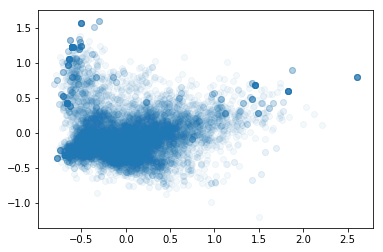

In [10]:
plt.scatter(pcafeatures[:,0], pcafeatures[:,1], alpha = 0.05);

### Histogram of cosine similarity distances in 2dim pc space 

Will help determine epsilon for DBSCAN later (maybe!)

##### Using non-scaled values 

In [14]:
cosine_pdist = pdist(pcafeatures, metric='cosine')

In [15]:
pcafeatures.shape

(11235, 2)

In [16]:
comb(11235, 2, exact=False, repetition=False)

63106995.0

In [17]:
cosine_pdist.shape

(63106995,)

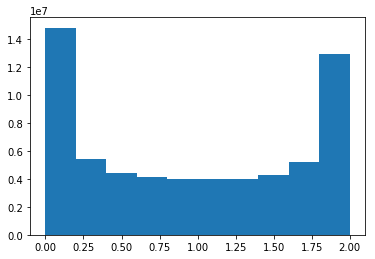

In [19]:
plt.hist(cosine_pdist); #bins = bin_widths);

Can set a concentration cutoff value - percentage or cumulative factor so as not to hard code a number here.

## Evaluate & optimize number of principal components 

Testing the variance explained for 1 to 150 (0 to 149) principal components. 

In [20]:
pca_tune = PCA(n_components=150)
pca_tune.fit(inclusion_df)
pcafeatures_tune = pca_tune.transform(inclusion_df)

Below explained variance won't add up to 1 because the explained variance drops. 

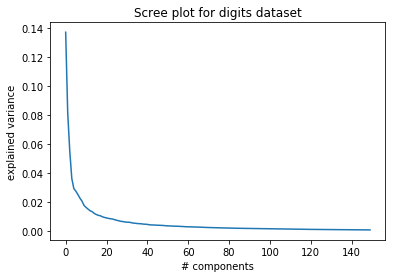

In [21]:
plt.plot(pca_tune.explained_variance_ratio_)
# plt.xlim(0,5)
plt.xlabel('# components')
plt.ylabel('explained variance');
plt.title('Scree plot for digits dataset');

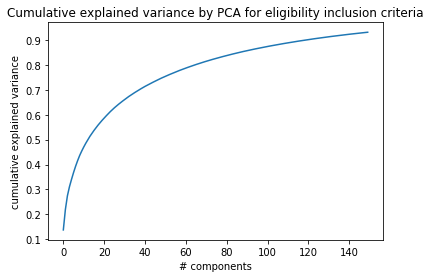

In [22]:
plt.plot(np.cumsum(pca_tune.explained_variance_ratio_))
plt.xlabel('# components')
plt.ylabel('cumulative explained variance');
plt.title('Cumulative explained variance by PCA for eligibility inclusion criteria');

### Setting cutoff for number of components: 85%

In [23]:
mask = (np.cumsum(pca_tune.explained_variance_ratio_)<0.85)

In [24]:
mask.sum()

86

In [25]:
threshhold_pca_features = pcafeatures_tune[:,mask]

In [26]:
threshhold_pca_features.shape

(11235, 86)

## Pickle reduced-dimension vectorized criteria (2D and 86D)

In [27]:
pickle.dump(pcafeatures, open("2D_pcafeatures.p", "wb"))

In [28]:
pickle.dump(threshhold_pca_features, open("86D_threshhold_pca_features.p", "wb"))